# 06 - Unsupervised Learning - Pokemon Dataset

The goal of this notebook is to develop an understanding how to apply and evaluate a cluster analysis. As an example, we like to cluster a pokemon data set.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/98/International_Pok%C3%A9mon_logo.svg/640px-International_Pok%C3%A9mon_logo.svg.png" width="500"/>

<div class="alert alert-block alert-info"> To solve this notebook you need the knowledge from the previous notebook. If you have problems solving it, take another look at the last week's notebooks.
    
It's also recommended to read the chapter 9 of the book in advance.</div>

**Task**: In this notebook we want to look for potential groups of pokemon using a cluster analysis on a [pokemon data set](https://www.kaggle.com/datasets/abcsds/pokemon). Parts of this notebook are inspired by [code from Jonathan Bernardo](https://www.kaggle.com/code/jbernardo/pokmeans-kmeans-clustering-in-pokedex).

In [1]:
# Run this cell two import the following modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
dataset = pd.read_csv('dataset/Pokemon.csv')
dataset.head()

#                   Name Type 1  Type 2  Total  HP  Attack  Defense  \
0  1              Bulbasaur  Grass  Poison    318  45      49       49   
1  2                Ivysaur  Grass  Poison    405  60      62       63   
2  3               Venusaur  Grass  Poison    525  80      82       83   
3  3  VenusaurMega Venusaur  Grass  Poison    625  80     100      123   
4  4             Charmander   Fire     NaN    309  39      52       43   

   Sp. Atk  Sp. Def  Speed  Generation  Legendary  
0       65       65     45           1      False  
1       80       80     60           1      False  
2      100      100     80           1      False  
3      122      120     80           1      False  
4       60       50     65           1      False

In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   #           800 non-null    int64 
 1   Name        800 non-null    object
 2   Type 1      800 non-null    object
 3   Type 2      414 non-null    object
 4   Total       800 non-null    int64 
 5   HP          800 non-null    int64 
 6   Attack      800 non-null    int64 
 7   Defense     800 non-null    int64 
 8   Sp. Atk     800 non-null    int64 
 9   Sp. Def     800 non-null    int64 
 10  Speed       800 non-null    int64 
 11  Generation  800 non-null    int64 
 12  Legendary   800 non-null    bool  
dtypes: bool(1), int64(9), object(3)
memory usage: 75.9+ KB


In the following you can find a small description of each feature:
- **#**: ID for each pokemon
- **Name**: Name of each pokemon
- **Type 1**: Each pokemon has a type, this determines weakness/resistance to attacks
- **Type 2**: Some pokemon are dual type and have 2
- **Total**: sum of all stats that come after this, a general guide to how strong a pokemon is
- **HP**: hit points, or health, defines how much damage a pokemon can withstand before fainting
- **Attack**: the base modifier for normal attacks (eg. Scratch, Punch)
- **Defense**: the base damage resistance against normal attacks
- **SP Atk**: special attack, the base modifier for special attacks (e.g. fire blast, bubble beam)
- **SP Def**: the base damage resistance against special attacks
- **Speed**: determines which pokemon attacks first each round

Because we want to do the cluster analysis based only on the skills of the Pokemon, the columns need to be filtered. For this, a list with the column names in square brackets can be written behind the dataframe.

In [4]:
skills = ['HP', 'Attack', 'Defense','Sp. Atk', 'Sp. Def', 'Speed']
dataset[skills].head()

HP  Attack  Defense  Sp. Atk  Sp. Def  Speed
0  45      49       49       65       65     45
1  60      62       63       80       80     60
2  80      82       83      100      100     80
3  80     100      123      122      120     80
4  39      52       43       60       50     65

To get a quick overview of the feature distribution, a boxplot is useful. This is shown in the following cell. 

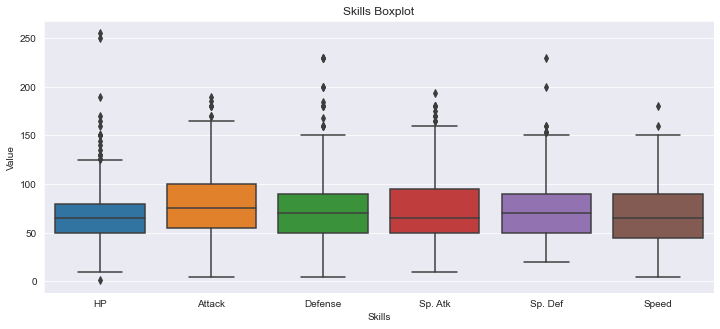

In [5]:
plt.figure(figsize=(12,5))
ax = sns.boxplot(data=dataset[skills])
plt.title("Skills Boxplot")
plt.xlabel("Skills")
plt.ylabel("Value");

As you can see, the features are all in almost the same scale. The plot also shows that there are a few outliers. However, these will not be discussed in this notebook. Whether the data is scaled similarly, the data should be standardized for cluster analysis since the k-means algorithm works distance-based. For this purpose, the StandardScaler of scikit-learn can be used, as in the past exercises.

In [6]:
from sklearn.preprocessing import StandardScaler

<div class="alert alert-block alert-success"><b>Task</b><br>
Use the StandardScaler scaler to standardize the data set. Since only the skill features are to be used for the cluster analysis, only these must be standardized. Store the standardized skill features in the variable dataset_scaled.
</div>

In [7]:
scaler = StandardScaler()
dataset_scaled = []
# Write Your Code Here
dataset_scaled = scaler.fit_transform(dataset[skills])
dataset_scaled

array([[-0.95062622, -0.92490618, -0.79715364, -0.2391303 , -0.24818854,
        -0.80150318],
       [-0.3628221 , -0.5241302 , -0.34791742,  0.21955954,  0.29115635,
        -0.28501525],
       [ 0.42091674,  0.09244823,  0.29384863,  0.83114599,  1.01028289,
         0.40363531],
       ...,
       [ 0.42091674,  0.95565803, -0.44418232,  2.36011211,  2.08897269,
         0.05931003],
       [ 0.42091674,  2.49710411, -0.44418232,  2.97169856,  2.08897269,
         0.40363531],
       [ 0.42091674,  0.95565803,  1.4811158 ,  1.74852566,  0.65071962,
         0.05931003]])

In this notebook we want to use the k-means algorithm. This algorithm is very efficient and works well on large data sets. However, one disadvantage is that the number of clusters must be set in advance. But there are different methods to determine the optimal number of clusters, which are described in detail in the book.

#### Elbow-Plot
The method consists of plotting the explained variation (Sum of squared distances of samples to their closest cluster center) as a function of the number of clusters, and picking the elbow of the curve as the number of clusters to use.

#### Silhoeutte-Plot
The method consists of plotting the mean silhoeutte score for all data points as a function of the number of clusters, and picking the highest value as the number of clusters to use.

In [8]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

For both methods the k-means algorithm must be applied for different number of clusters. Afterwards, the metrics can be computed and plotted as a function of the number of clusters. Here we try different k in the range of 1 to 15. The silhouette score can be only computed for k>1, therefore it is skipped in the first iteration.

In [9]:
n_max_clusters = 15
# Elbow Method
inertias = []
silhouettes = []
for cluster in range(1,n_max_clusters):
    kmeans_f = KMeans(n_clusters = cluster, init="k-means++", random_state=42)
    labels = kmeans_f.fit_predict(dataset_scaled)
    inertias.append(kmeans_f.inertia_)
    if cluster > 1:
        silhouettes.append(silhouette_score(dataset_scaled, labels))

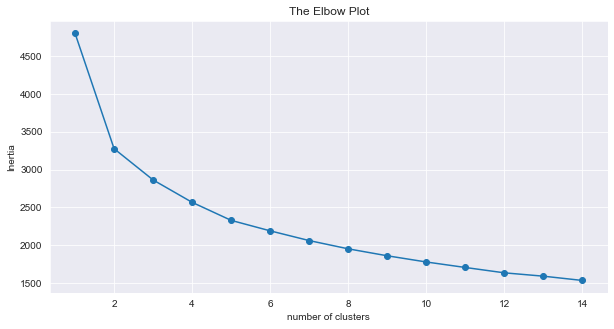

In [10]:
plt.figure(figsize=(10,5))
plt.plot(range(1,n_max_clusters), inertias, linestyle='-', marker='o')
plt.title('The Elbow Plot')
plt.xlabel('number of clusters')
plt.ylabel('Inertia');

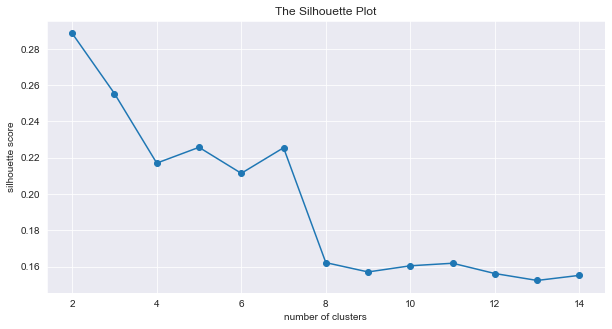

In [11]:
plt.figure(figsize=(10,5))
plt.plot(range(2,n_max_clusters), silhouettes, linestyle='-', marker='o')
plt.title('The Silhouette Plot')
plt.xlabel('number of clusters')
plt.ylabel('silhouette score');

To determine the optimal number of clusters in the elbow-plot, we have to select the value of k at the “elbow”, i.e. the point after which the inertia starts decreasing in a linear way. Thus for the given data, we assume that the optimal number of clusters for the data is 2. Since two groups are very few clusters, you can see the next slight "elbow" at k=5. Looking at the silhouette plot at k=5 we see a local maximum. However, it must be noted that all silhouette scores are <0.3. This means that all clusters are very close to each other.

After we have found a good value for k, we can run the algorithm again with the optimal parameter.

<div class="alert alert-block alert-success"><b>Task</b><br>
Use the k-Means implementation of scikit-learn to determine the cluster label for each data point. First fit the model to the scaled data set and then create a new column in the DataFrame dataset with the name 'cluster_labels', where you save the labels for each row in the data set. You can access the variables with kmeans.labels_.
</div>

In [12]:
k = 5
kmeans = KMeans(n_clusters = k, init="k-means++", random_state=42)
# Write Your Code Here
y_kmeans = kmeans.fit(dataset_scaled)
dataset['cluster_labels'] = kmeans.labels_.transpose().tolist()
dataset

#                   Name   Type 1  Type 2  Total  HP  Attack  Defense  \
0      1              Bulbasaur    Grass  Poison    318  45      49       49   
1      2                Ivysaur    Grass  Poison    405  60      62       63   
2      3               Venusaur    Grass  Poison    525  80      82       83   
3      3  VenusaurMega Venusaur    Grass  Poison    625  80     100      123   
4      4             Charmander     Fire     NaN    309  39      52       43   
..   ...                    ...      ...     ...    ...  ..     ...      ...   
795  719                Diancie     Rock   Fairy    600  50     100      150   
796  719    DiancieMega Diancie     Rock   Fairy    700  50     160      110   
797  720    HoopaHoopa Confined  Psychic   Ghost    600  80     110       60   
798  720     HoopaHoopa Unbound  Psychic    Dark    680  80     160       60   
799  721              Volcanion     Fire   Water    600  80     110      120   

     Sp. Atk  Sp. Def  Speed  Generation  Legendary  cluster_labels  
0         65       65     45           1      False               2  
1         80       80     60           1      False               1  
2        100      100     80           1      False               1  
3        122      120     80           1      False               4  
4         60       50     65           1      False               2  
..       ...      ...    ...         ...        ...             ...  
795      100      150     50           6       True               0  
796      160      110    110           6       True               4  
797      150      130     70           6       True               4  
798      170      130     80           6       True               4  
799      130       90     70           6       True               4  

[800 rows x 14 columns]

To get an overview of of the cluster you can create a pairplot, which is a scatterplot for each feature combination, and colorize the data points according to their cluster label.

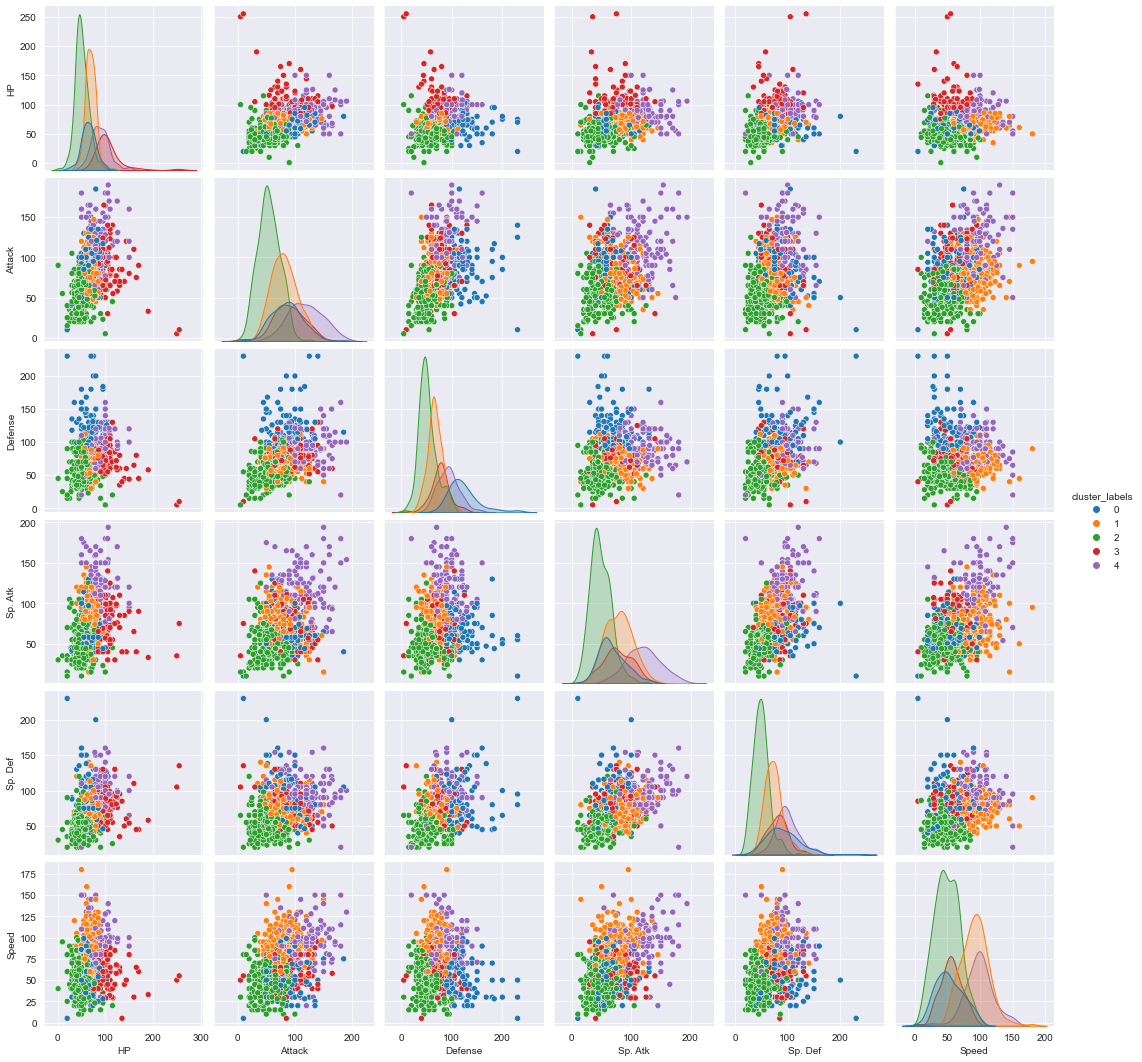

In [13]:
sns.pairplot(dataset[skills + ['cluster_labels']], hue="cluster_labels", palette='tab10');

In the pairplot, you can already see, that cluster 2 (green dots) are the weakest group, because they are located at the bottom left of the graph in almost all skill. On the other hand, cluster 4 (purple points) are the strongest group of Pokemon.

To check that, we can analyze the distribution of Legendary Pokemon over the clusters.

<AxesSubplot:xlabel='Legendary', ylabel='count'>

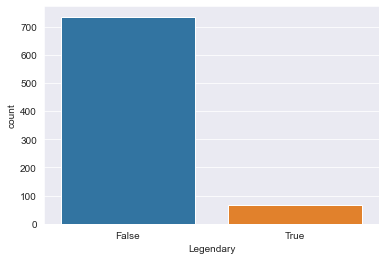

In [14]:
sns.countplot(x='Legendary', data=dataset)

As this countplot show, the Legendary Pokemon are very rare in the data set.

Text(0, 0.5, 'count')

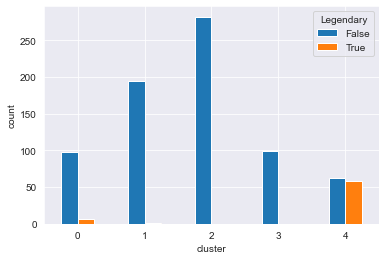

In [15]:
ax = dataset.groupby(['cluster_labels', 'Legendary']).size().unstack(level=-1).plot.bar()
ax.set_xticklabels(range(0,k), rotation=0)
ax.set_xlabel('cluster')
ax.set_ylabel('count')

As expected, we can find the the most Legendary Pokemon in cluster 4, which we determined as the strongest cluster, but there are also a few in cluster 0 and 1.

Next, we can examine the centroids computed when performing the k-Means. Since the values are standardized we must retransform them into the original scale with the StandardScaler. For a better overview, we can represent the values in a heatmap, too.

HP      Attack     Defense     Sp. Atk    Sp. Def      Speed
cluster                                                                      
0         64.711538   86.336538  123.125000   68.144231  92.076923  53.000000
1         67.979487   81.333333   66.641026   79.041026  73.466667  91.825641
2         50.358156   54.159574   51.741135   48.258865  49.131206  49.173759
3        106.141414   89.505051   76.353535   77.757576  80.171717  55.747475
4         89.266667  118.566667   92.700000  120.408333  98.566667  98.483333

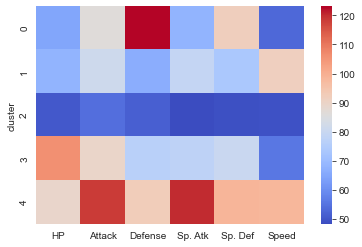

In [16]:
cluster_centroids_df = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=skills)
cluster_centroids_df.index = cluster_centroids_df.index.rename(name='cluster')
sns.heatmap(cluster_centroids_df, cmap="coolwarm")
cluster_centroids_df

For a better understanding, we can also determine the data point that is closest to the cluster center. The interpretation of the clusters in described below.

In [17]:
dataset["distance_to_centroid"] = np.mean(kmeans.transform(dataset_scaled), axis=1)
cluster_representations = dataset.iloc[dataset.groupby('cluster_labels')['distance_to_centroid'].idxmin()]

# Cluster Representations

## Cluster 0 - The Defensive Squad

> The highest Skills are Defense and Special Defense

> Defensive, Special Defense and Attack are the Top 3 Skills 

> Nearest Pokemon to Cluster centroids: **Meganium**

> <img src="https://www.pokewiki.de/images/e/e7/Sugimori_154.png" width="200" align="left"/>

In [18]:
# Pokemon Stats
cluster_representations.iloc[0]

#                            154
Name                    Meganium
Type 1                     Grass
Type 2                       NaN
Total                        525
HP                            80
Attack                        82
Defense                      100
Sp. Atk                       83
Sp. Def                      100
Speed                         80
Generation                     2
Legendary                  False
cluster_labels                 0
distance_to_centroid    1.934608
Name: 168, dtype: object

## Cluster 1 - Speedy Squad

> Cluster of the fastest Pokemons

> Speed, Attack and Special Attack are the Top 3 Skills

> Nearest Pokemon to Cluster centroids: **Glalie**

> <img src="https://www.pokewiki.de/images/6/68/Sugimori_362.png" width="200" align="left"/>


In [19]:
# Pokemon Stats
cluster_representations.iloc[1]

#                            362
Name                      Glalie
Type 1                       Ice
Type 2                       NaN
Total                        480
HP                            80
Attack                        80
Defense                       80
Sp. Atk                       80
Sp. Def                       80
Speed                         80
Generation                     3
Legendary                  False
cluster_labels                 1
distance_to_centroid    1.703389
Name: 396, dtype: object

## Cluster 2 - Weakest Pokemons Cluster

> The weakest Pokemons, low values for all the Skills

> Nearest Pokemon to Cluster centroids: **Eelektrik**

> <img src="https://www.pokewiki.de/images/8/8d/Sugimori_603.png" width="200" align="left"/>

In [20]:
# Pokemon Stats
cluster_representations.iloc[2]

#                             603
Name                    Eelektrik
Type 1                   Electric
Type 2                        NaN
Total                         405
HP                             65
Attack                         85
Defense                        70
Sp. Atk                        75
Sp. Def                        70
Speed                          40
Generation                      5
Legendary                   False
cluster_labels                  2
distance_to_centroid     2.060464
Name: 664, dtype: object

## Cluster 3 - High HP and Slow Speed Cluster

> They have High HP and Slow Speed

> HP, Attack and Special Defense are the top 3 skills

> Nearest Pokemon to Cluster centroids: **Malamar**

> <img src="https://www.pokewiki.de/images/5/5c/Sugimori_687.png" width="200" align="left"/>


In [21]:
# Pokemon Stats
cluster_representations.iloc[3]

#                            687
Name                     Malamar
Type 1                      Dark
Type 2                   Psychic
Total                        482
HP                            86
Attack                        92
Defense                       88
Sp. Atk                       68
Sp. Def                       75
Speed                         73
Generation                     6
Legendary                  False
cluster_labels                 3
distance_to_centroid    1.763953
Name: 757, dtype: object

## Cluster 4 - The Overpowering Squad

> The strongest Pokemons have high values for all skills

> Speed, Attack and Special Attack are the top 3 skills

> Most legendary Pokemon in this cluster

> Nearest Pokemon to Cluster centroids: **Kingdra**

> <img src="https://www.pokewiki.de/images/2/2d/Sugimori_230.png" width="200" align="left"/>


In [22]:
# Pokemon Stats
cluster_representations.iloc[4]

#                            230
Name                     Kingdra
Type 1                     Water
Type 2                    Dragon
Total                        540
HP                            75
Attack                        95
Defense                       95
Sp. Atk                       95
Sp. Def                       95
Speed                         85
Generation                     2
Legendary                  False
cluster_labels                 4
distance_to_centroid    1.910488
Name: 249, dtype: object

## Additional task: DBSCAN

A second well-known cluster algorithm is DBSCAN. You can find detailed information about this algorithm in the book. Two important hypterparameters are $\epsilon$ and MinPts.

- Minimum samples (“MinPts”): the fewest number of points required to form a cluster
- $\epsilon$: the maximum distance two points can be from one another while still belonging to the same cluster

<div class="alert alert-block alert-success"><b>Task</b><br>
Play around with different values for the hyperparameters epsilon and MinPts. You can use the visualizations below the examine the cluster result.
</div>

In [23]:
from sklearn.cluster import DBSCAN

In [24]:
def generate_dbscan_cluster(df, dataset_scaled, epsilon=1, MinPts=30):
    dataset = df.copy()
    dbscan = DBSCAN(eps=epsilon, min_samples=MinPts, metric='euclidean')
    dbscan.fit(dataset_scaled)
    dataset['dbscan_labels'] = dbscan.labels_

    sns.countplot(x='dbscan_labels', data=dataset)
    plt.xlabel('cluster')

    sns.pairplot(data=dataset[skills + ['dbscan_labels']], hue='dbscan_labels', palette='tab10')

    ax = dataset.groupby(['dbscan_labels', 'Legendary']).size().unstack(level=-1).plot.bar()
    ax.set_xticklabels(range(-1,len(np.unique(dbscan.labels_))-1), rotation=0)
    ax.set_xlabel('cluster')
    ax.set_ylabel('count')

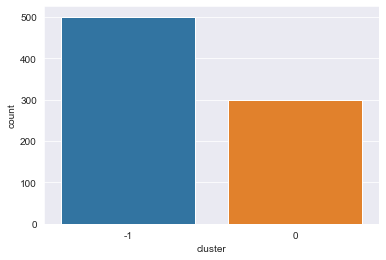

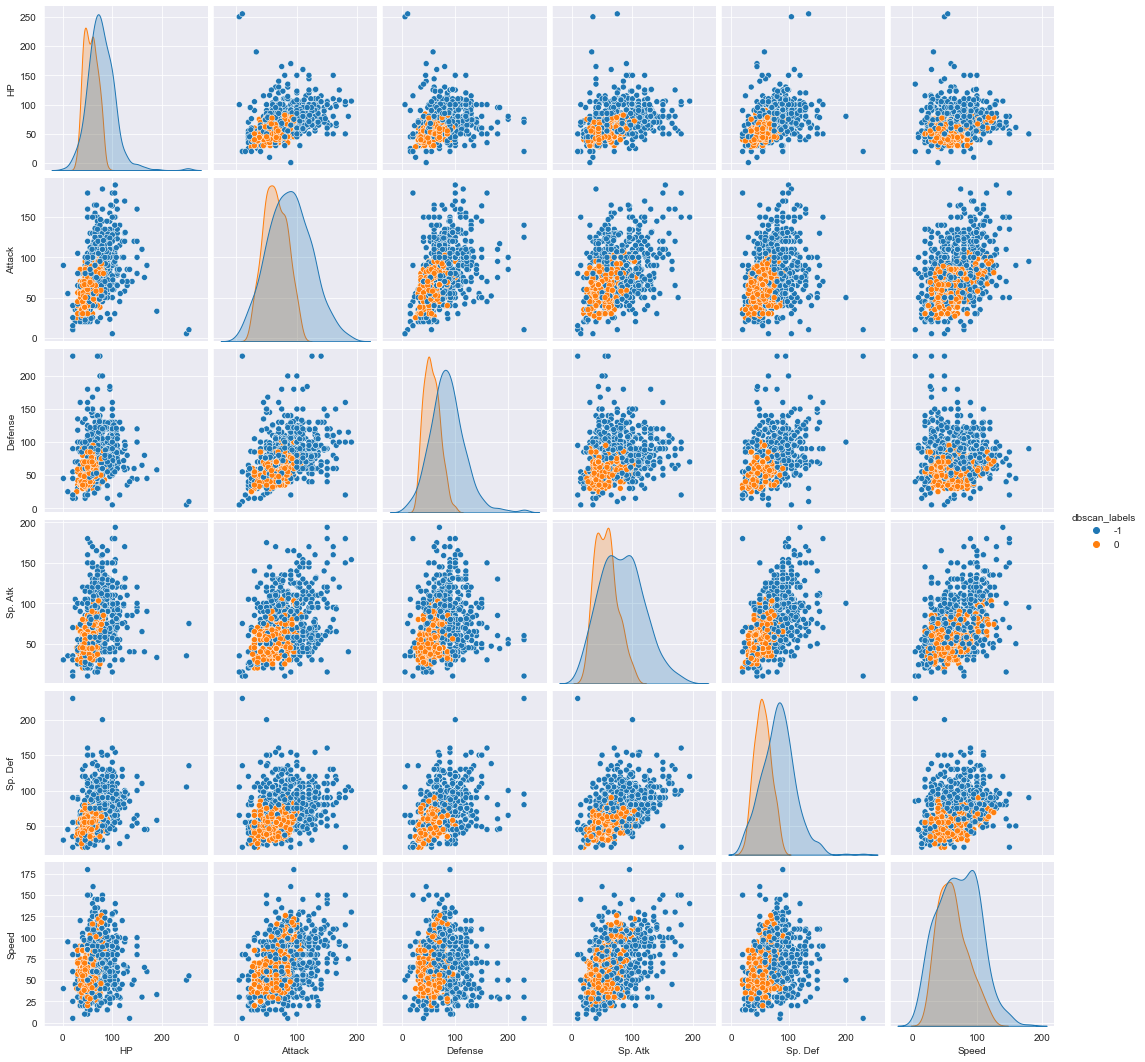

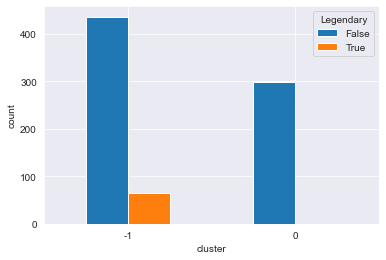

In [25]:
generate_dbscan_cluster(dataset, dataset_scaled)

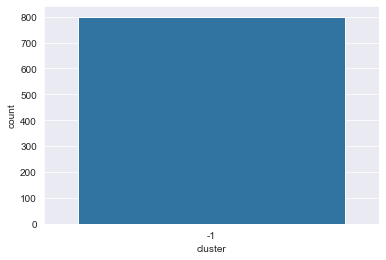

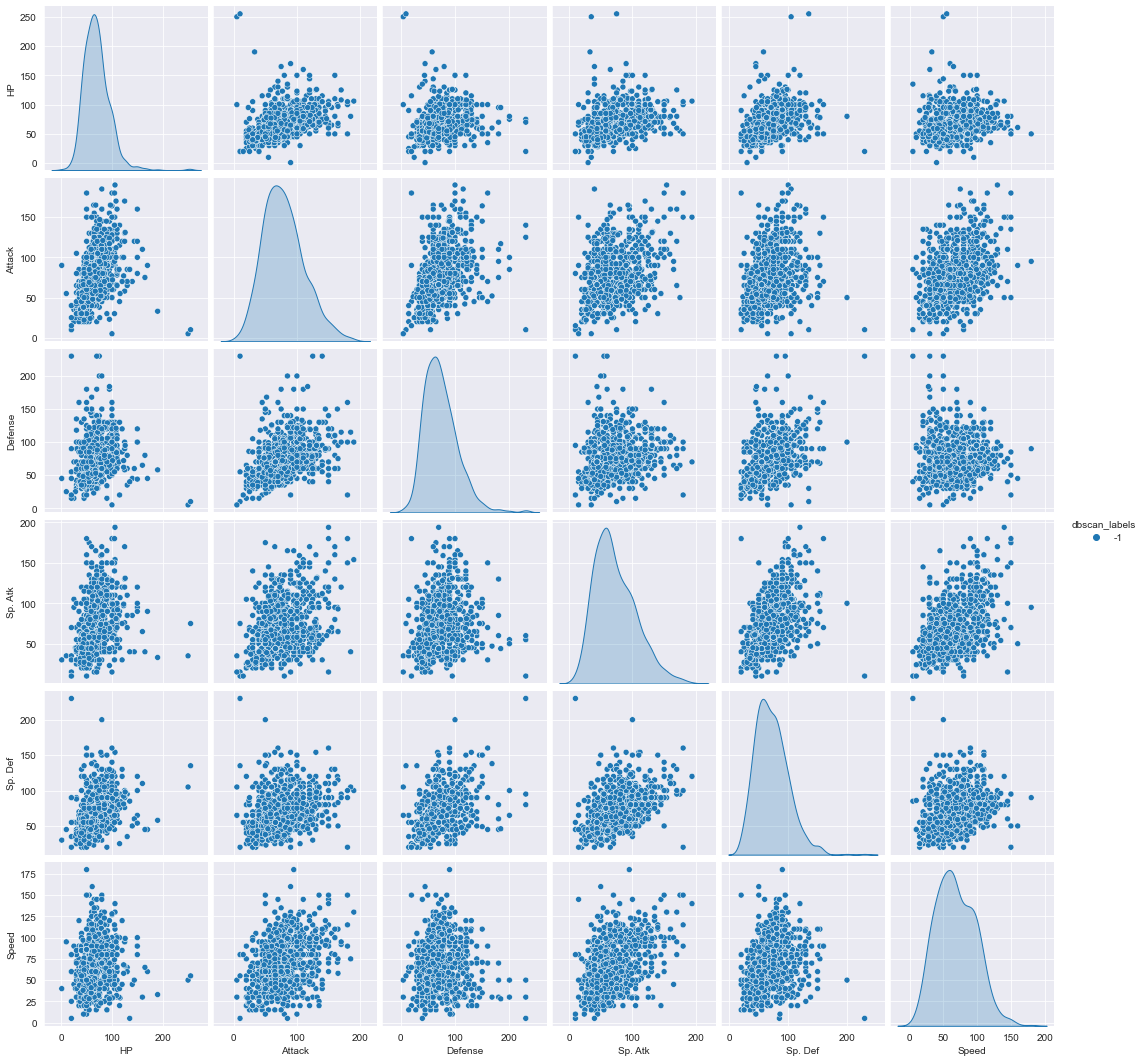

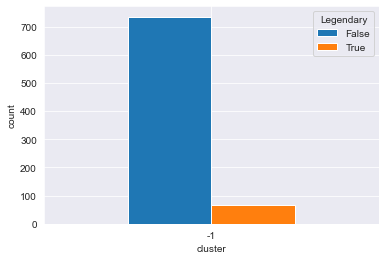

In [26]:
generate_dbscan_cluster(dataset, dataset_scaled, epsilon=0.5, MinPts=60)

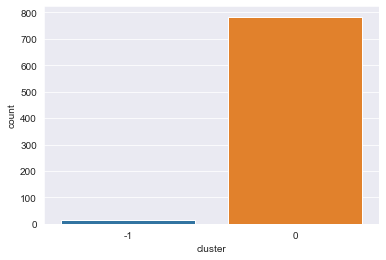

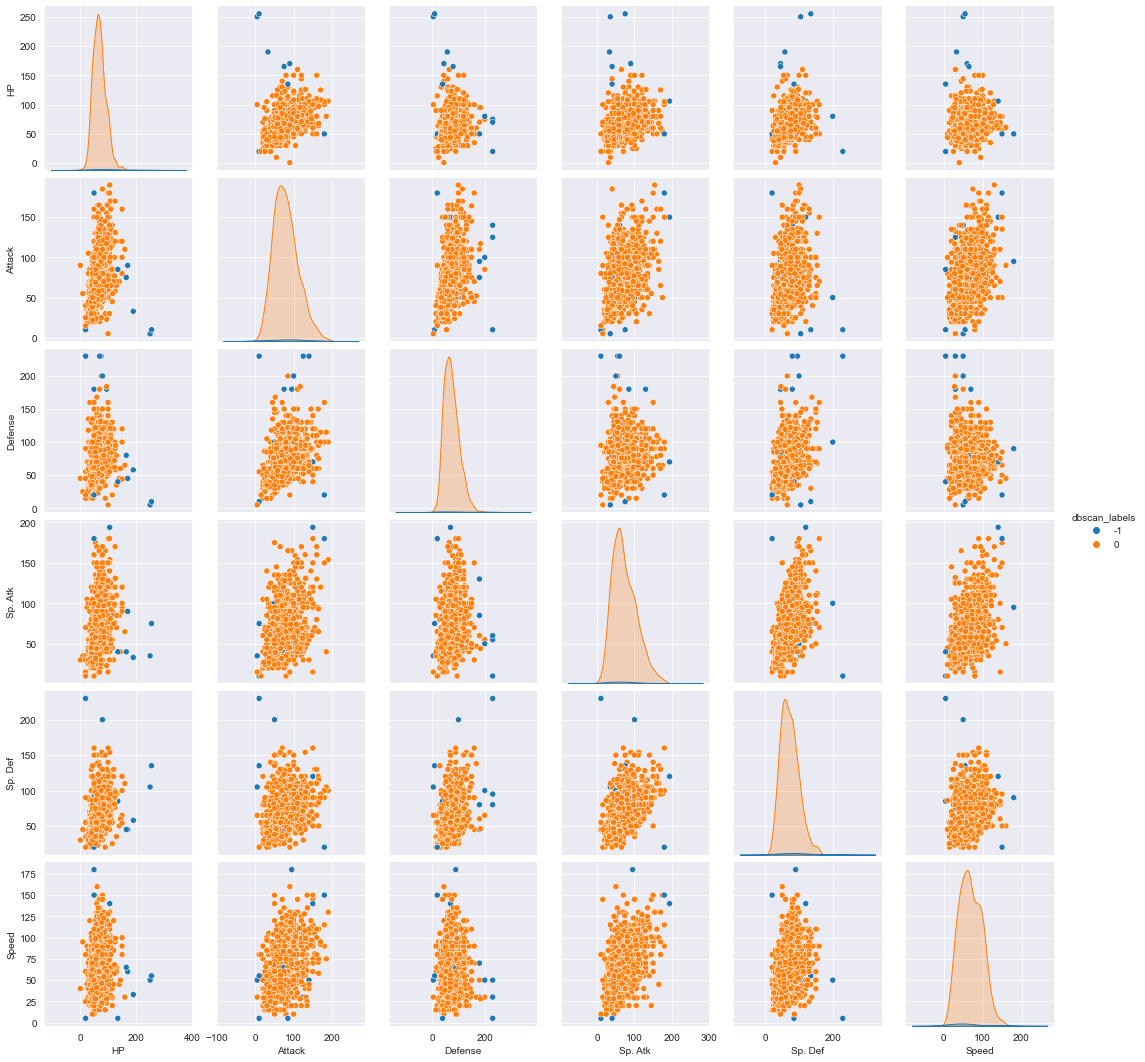

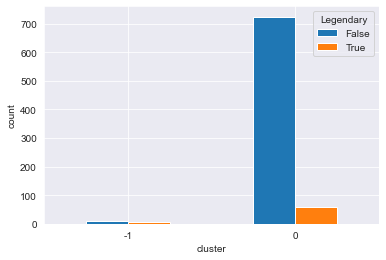

In [27]:
generate_dbscan_cluster(dataset, dataset_scaled, epsilon=2, MinPts=15)

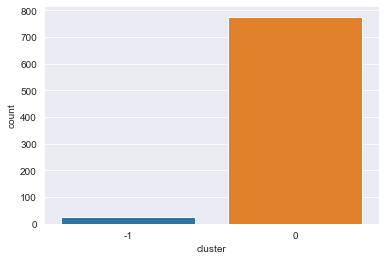

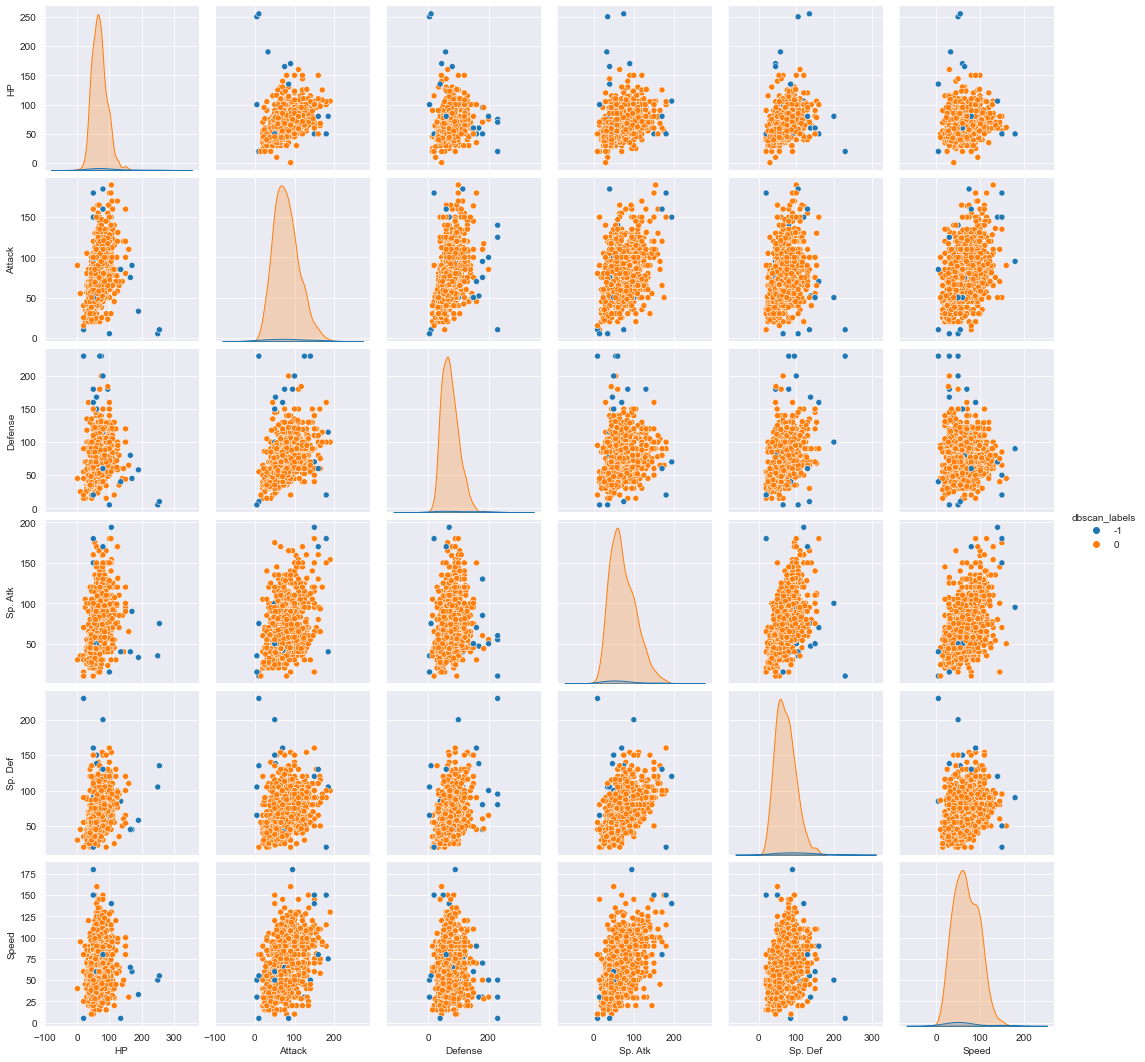

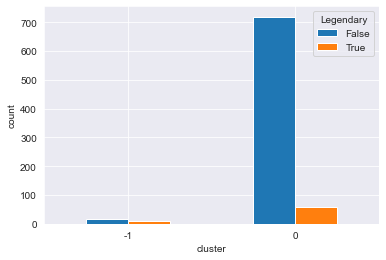

In [28]:
generate_dbscan_cluster(dataset, dataset_scaled, epsilon=2, MinPts=30)

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


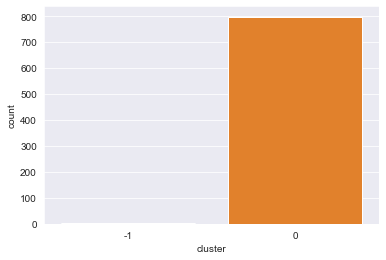

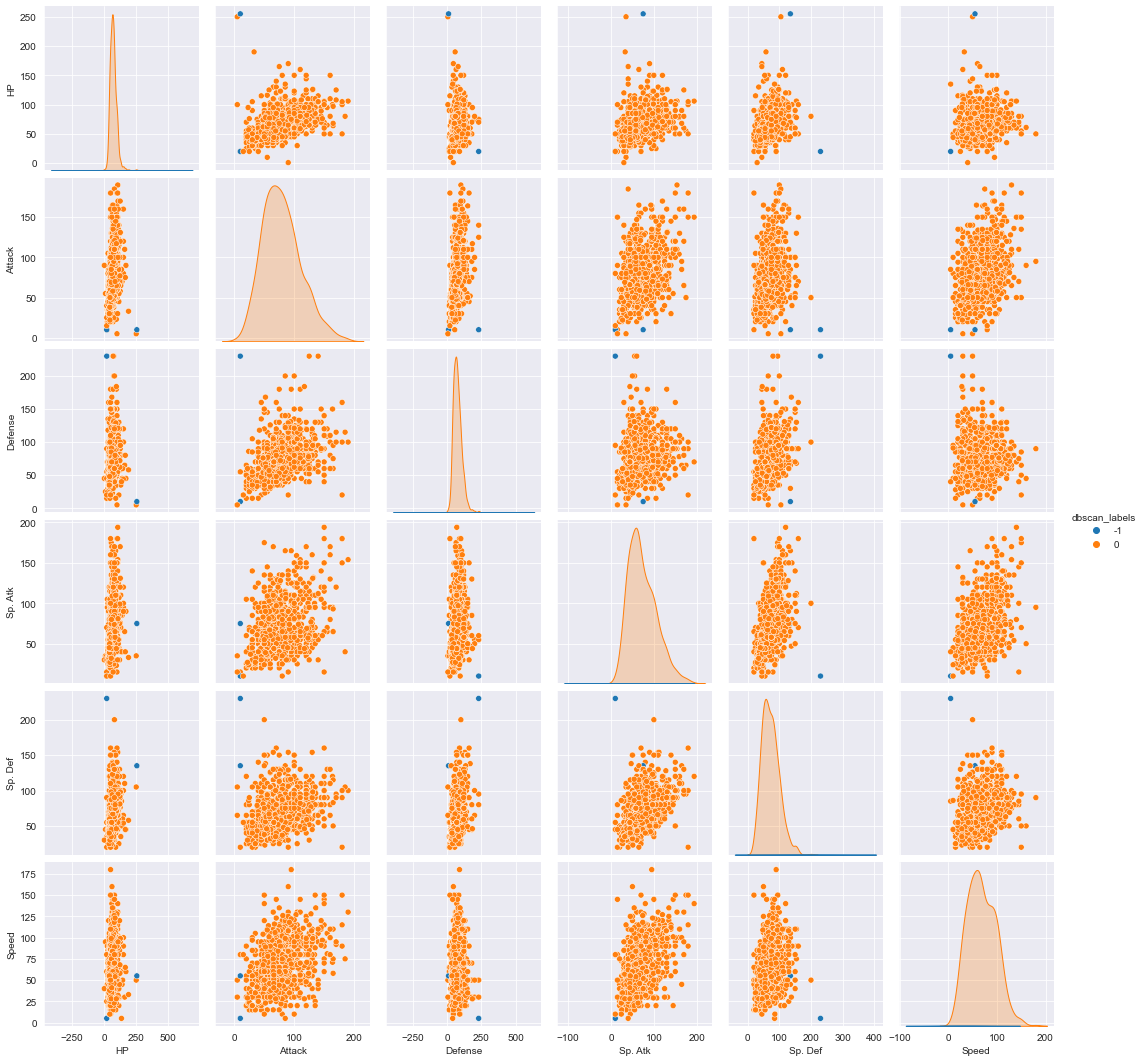

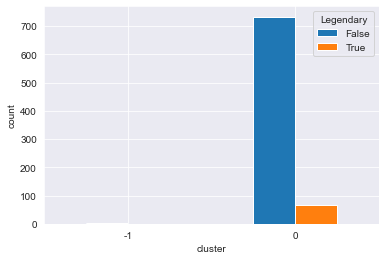

In [29]:
generate_dbscan_cluster(dataset, dataset_scaled, epsilon=4, MinPts=15)

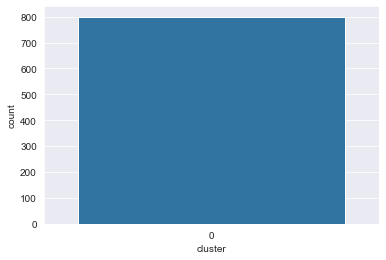

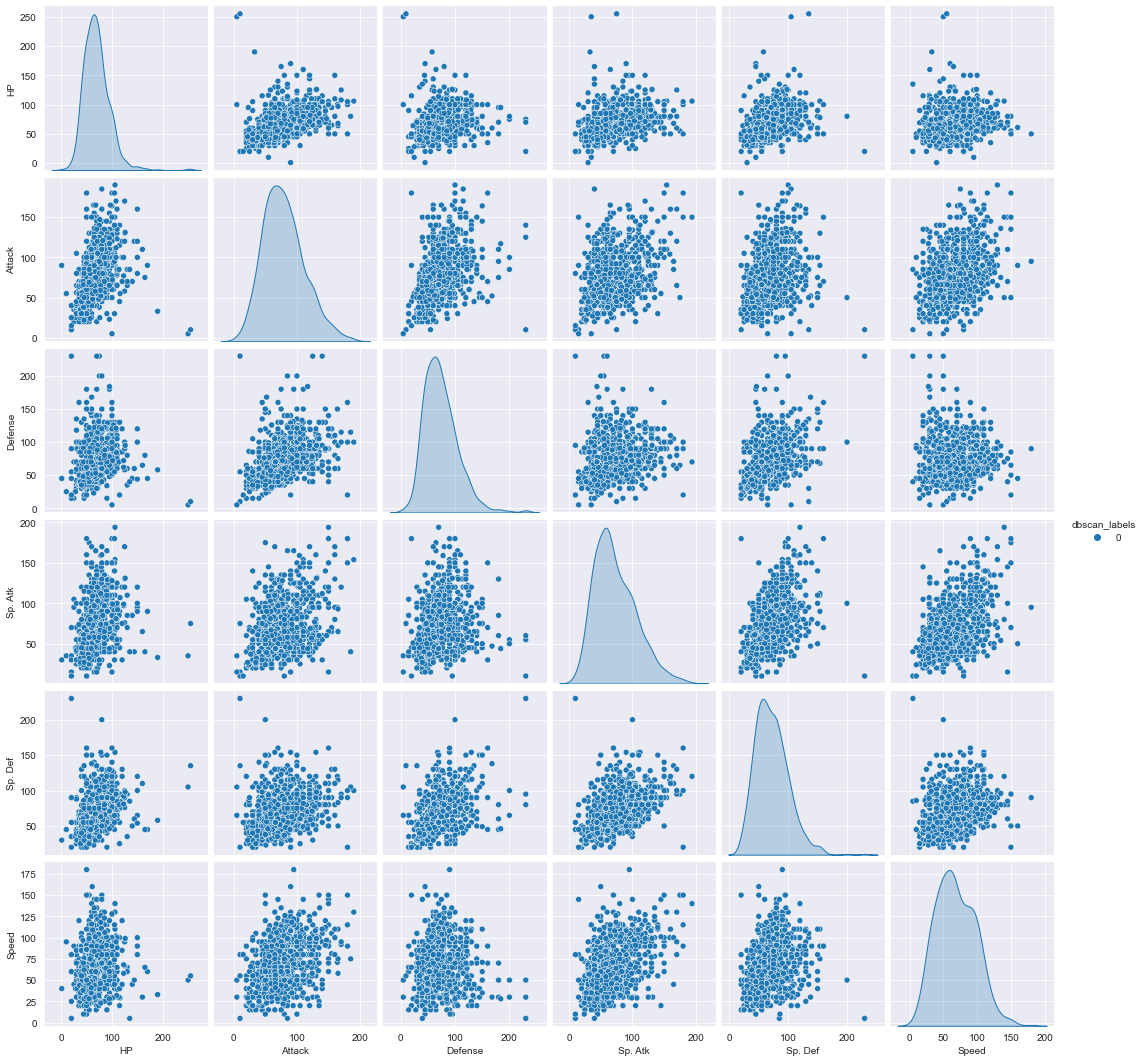

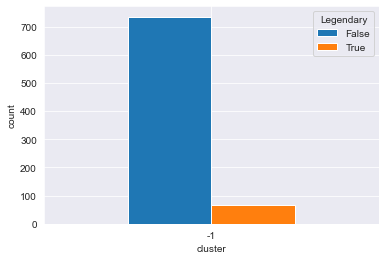

In [32]:
generate_dbscan_cluster(dataset, dataset_scaled, epsilon=7, MinPts=55)

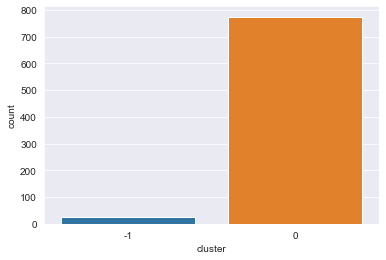

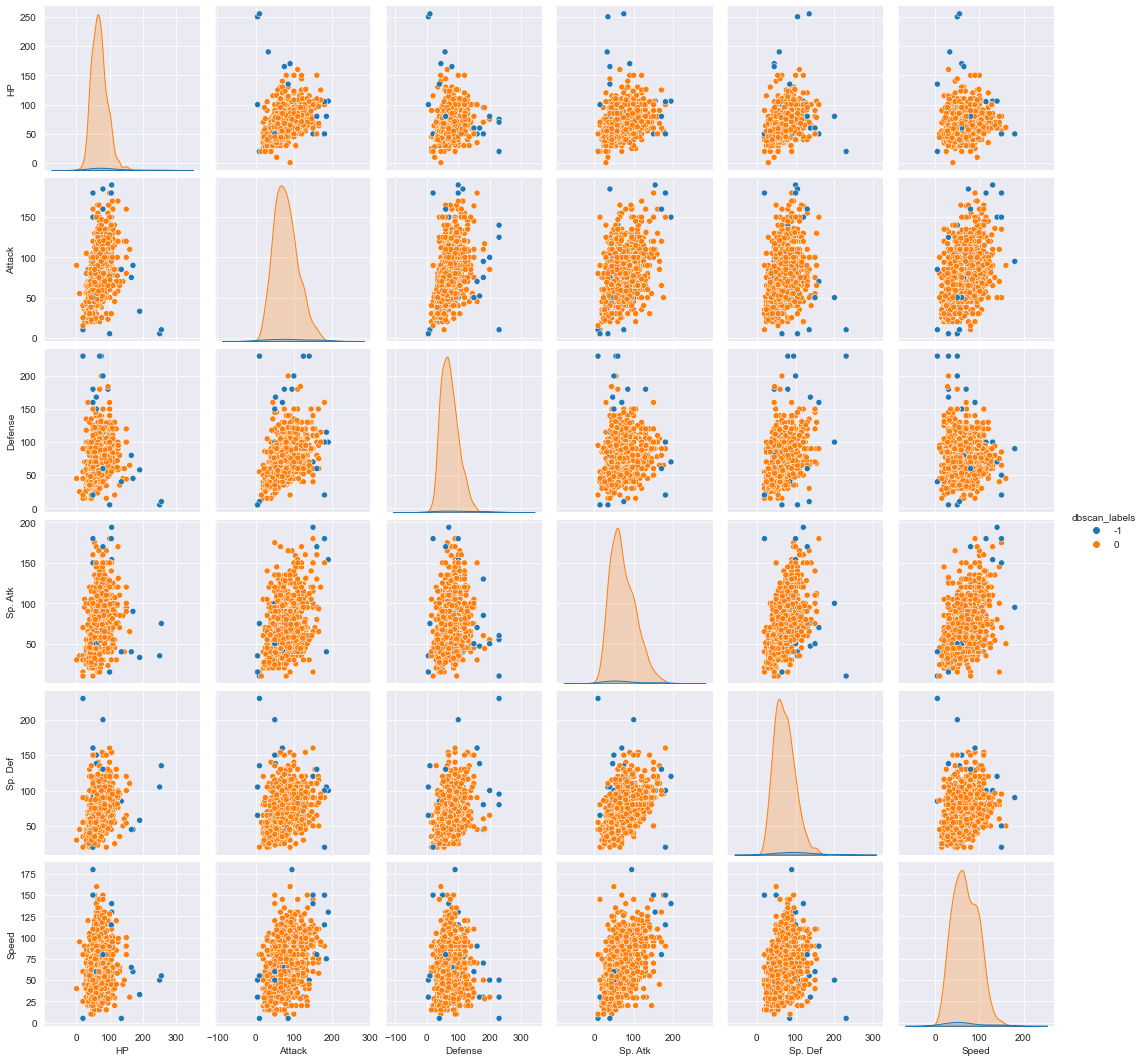

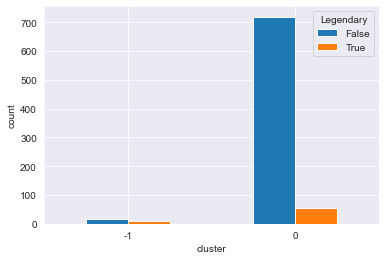

In [33]:
generate_dbscan_cluster(dataset, dataset_scaled, epsilon=2, MinPts=35)

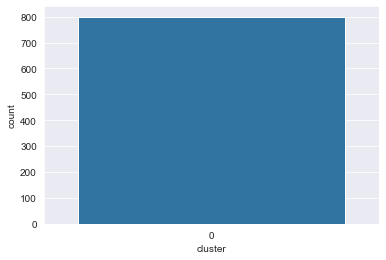

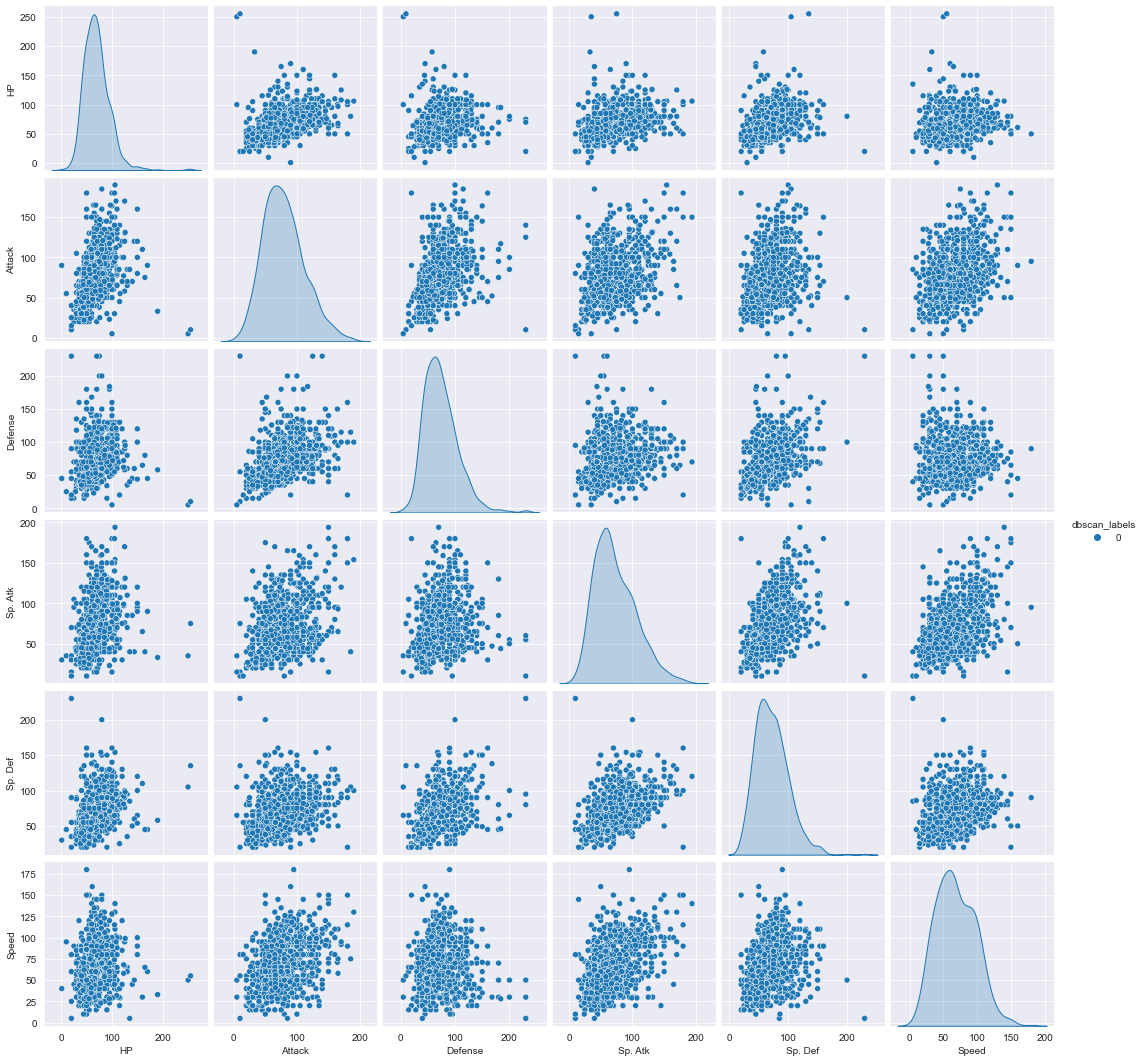

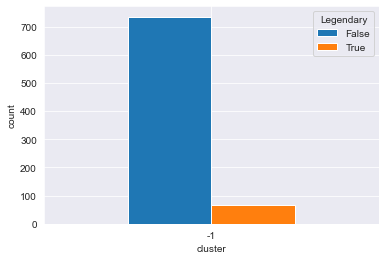

In [36]:
generate_dbscan_cluster(dataset, dataset_scaled, epsilon=5, MinPts=95)